# Ecosystem Services Valuation Workflow

This notebook follows the 11-phase roadmap from the project README. Fill in each section sequentially to maintain provenance and reproducibility.

## 0. Setup
- Activate the `biomass` environment (`conda activate biomass`).
- Update the project path, AOI coordinates, and CDSE credentials in the cells below.

### 0.1 Import libraries and load data

In [12]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject
from rasterio.io import MemoryFile
from pathlib import Path
from typing import Optional, Dict, Tuple
from contextlib import ExitStack
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling

print("Core libraries imported.")

BAND_SPECS = {
    "B02": {"label": "blue", "folder": "R10m", "suffix": "10m"},
    "B03": {"label": "green", "folder": "R10m", "suffix": "10m"},
    "B04": {"label": "red", "folder": "R10m", "suffix": "10m"},
    "B08": {"label": "nir", "folder": "R10m", "suffix": "10m"},
    "B11": {"label": "swir1", "folder": "R20m", "suffix": "20m"},
    "B12": {"label": "swir2", "folder": "R20m", "suffix": "20m"},
}

SCALING_FACTOR = 10000.0
PIXEL_AREA_HA_10M = 0.01

Core libraries imported.


In [2]:
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)
print(f"Data directory: {DATA_DIR}")

SAFE_PATTERN = "S2C_MSIL2A_*.SAFE"
SAFE_ROOTS = sorted(DATA_DIR.glob(SAFE_PATTERN))
if not SAFE_ROOTS:
    raise FileNotFoundError(
        f"No Sentinel-2 SAFE directories found via pattern '{SAFE_PATTERN}' in {DATA_DIR}"
    )
print(f"Found {len(SAFE_ROOTS)} SAFE folders inside data/:")
for safe in SAFE_ROOTS:
    print(" •", safe.name)

ANCILLARY_DIR = DATA_DIR / "ancillary"
ANCILLARY_DIR.mkdir(exist_ok=True)
print(f"Ancillary data directory: {ANCILLARY_DIR}")

AOI_PATH = DATA_DIR / "aoi.geojson"
if AOI_PATH.exists():
    print(f"AOI file detected: {AOI_PATH}")
else:
    print(f"AOI file not found (expected at {AOI_PATH}). Drop a GeoJSON/shapefile copy there when ready.")


Data directory: /home/fred/Projects/Feishu-Hack/Biomass_fun/data
Found 2 SAFE folders inside data/:
 • S2C_MSIL2A_20251113T024511_N0511_R089_T50RQV_20251113T054013.SAFE
 • S2C_MSIL2A_20251113T024511_N0511_R089_T51RTQ_20251113T054013.SAFE
Ancillary data directory: /home/fred/Projects/Feishu-Hack/Biomass_fun/data/ancillary
AOI file detected: /home/fred/Projects/Feishu-Hack/Biomass_fun/data/aoi.geojson


### 0.2 Function Support

In [3]:
def load_optional_vector(path: Path) -> Optional[gpd.GeoDataFrame]:
    if not path.exists():
        return None
    gdf = gpd.read_file(path)
    print(f"Loaded vector data from {path} ({len(gdf)} features, CRS={gdf.crs})")
    return gdf.to_crs("EPSG:4326") if gdf.crs else gdf

AOI_GDF = load_optional_vector(AOI_PATH)
if AOI_GDF is None:
    print("AOI_GDF not loaded yet. Provide a GeoJSON/GeoPackage/Shapefile in data/.")
else:
    # Reproject to a projected CRS (UTM zone 50N for this region) for accurate centroid calculation
    aoi_projected = AOI_GDF.to_crs("EPSG:32650")  # UTM Zone 50N
    centroid_projected = aoi_projected.geometry.centroid.union_all()
    # Convert back to WGS84 for display
    AOI_CENTROID = gpd.GeoSeries([centroid_projected], crs="EPSG:32650").to_crs("EPSG:4326")[0]
    print(f"AOI centroid: ({AOI_CENTROID.y:.4f}, {AOI_CENTROID.x:.4f})")

def get_granule_dir(safe_dir: Path) -> Path:
    granules = sorted((safe_dir / "GRANULE").iterdir())
    if not granules:
        raise FileNotFoundError(f"No GRANULE directory found in {safe_dir}")
    return granules[0]

def find_band_path(safe_dir: Path, band_id: str) -> Path:
    """Find a band file inside a Sentinel-2 SAFE folder, searching IMG_DATA recursively."""
    spec = BAND_SPECS[band_id]
    granule = get_granule_dir(safe_dir)

    search_root = granule / "IMG_DATA"
    suffix = spec["suffix"]
    pattern = f"*_{band_id}_{suffix}.jp2"

    matches = sorted(search_root.rglob(pattern))
    if not matches:
        raise FileNotFoundError(
            f"Band {band_id} not found in {safe_dir}\n"
            f"Looked under {search_root} with pattern '{pattern}'"
        )

    print(f"{band_id}: using {matches[0].relative_to(safe_dir)}")
    return matches[0]

def find_quality_mask(safe_dir: Path, filename: str) -> Path:
    granule = get_granule_dir(safe_dir)
    candidate = granule / "QI_DATA" / filename
    if not candidate.exists():
        raise FileNotFoundError(f"Quality mask {filename} missing in {safe_dir}")
    return candidate

def resample_to_target(array: np.ndarray, src_transform, src_crs, dst_profile, resampling=Resampling.bilinear):
    """Resample array to match target profile using rasterio reproject"""
    dst_transform = dst_profile["transform"]
    dst_width = dst_profile["width"]
    dst_height = dst_profile["height"]
    dst_crs = dst_profile["crs"]
    
    # Create destination array
    dst_array = np.zeros((dst_height, dst_width), dtype=array.dtype)
    
    reproject(
        source=array,
        destination=dst_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=resampling
    )
    
    return dst_array

def merge_datasets(paths, dst_profile=None, resampling=Resampling.bilinear):
    """
    Handle tiles in different CRS by forcing common projection
    """
    with ExitStack() as stack:
        datasets = [stack.enter_context(rasterio.open(p)) for p in paths]
        
        crs_list = [src.crs for src in datasets]
        unique_crs = set(crs_list)
        
        if dst_profile is not None and "crs" in dst_profile:
            dst_crs = dst_profile["crs"]
        else:
            dst_crs = max(set(crs_list), key=crs_list.count) if crs_list else datasets[0].crs
        
        reproj_datasets = []
        memfiles = []
        
        for i, src in enumerate(datasets):
            if src.crs == dst_crs:
                reproj_datasets.append(src)
                continue
                
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds
            )
            
            profile = src.profile.copy()
            profile.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height,
                'nodata': 0
            })
            
            memfile = MemoryFile()
            memfiles.append(memfile)
            dst = memfile.open(**profile)
            stack.enter_context(dst)
            
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=resampling,
                nodata=0
            )
            
            reproj_datasets.append(dst)
        
        mosaic, out_transform = merge(
            reproj_datasets,
            method='first',
            nodata=0,
            resampling=resampling
        )
        
        profile = reproj_datasets[0].profile.copy()
        profile.update({
            'height': mosaic.shape[1],
            'width': mosaic.shape[2],
            'transform': out_transform
        })
        
        return mosaic[0], profile

def load_band(band_id: str, dst_profile=None, resampling=Resampling.bilinear):
    paths = [find_band_path(safe, band_id) for safe in SAFE_ROOTS]
    
    # For 20m bands, first merge at native resolution, then resample
    spec = BAND_SPECS[band_id]
    if spec["suffix"] == "20m" and dst_profile is not None:
        # Merge at native 20m resolution first
        arr_20m, profile_20m = merge_datasets(paths, dst_profile=None, resampling=resampling)
        
        # Then resample to 10m target
        arr_10m = resample_to_target(
            arr_20m, 
            profile_20m["transform"], 
            profile_20m["crs"],
            dst_profile,
            resampling=resampling
        )
        return arr_10m, dst_profile
    else:
        # 10m bands can be merged directly to target
        return merge_datasets(paths, dst_profile=dst_profile, resampling=resampling)

def to_reflectance(array: np.ndarray) -> np.ndarray:
    return (array.astype(np.float32) / SCALING_FACTOR).clip(0, 1.2)

def create_aoi_mask(profile: dict, aoi_gdf: gpd.GeoDataFrame):
    """Create a binary mask for AOI without any file operations"""
    if aoi_gdf is None or aoi_gdf.empty:
        return None
    
    # Ensure AOI is in raster CRS
    aoi_projected = aoi_gdf.to_crs(profile["crs"])
    
    # Create mask directly
    mask_shape = (profile['height'], profile['width'])
    
    aoi_mask = rasterio.features.rasterize(
        [(geom, 1) for geom in aoi_projected.geometry],
        out_shape=mask_shape,
        transform=profile['transform'],
        fill=0,
        all_touched=False,
        dtype=np.uint8
    )
    
    return aoi_mask

def apply_aoi_mask(array: np.ndarray, aoi_mask: np.ndarray):
    """Apply AOI mask to array"""
    if aoi_mask is None:
        return array
    
    if array.ndim == 3:
        # RGB: (height, width, bands) or (bands, height, width)
        if array.shape[0] == 3:  # (bands, height, width)
            return array * aoi_mask  # Broadcasting works
        else:  # (height, width, bands)
            return array * aoi_mask[:, :, np.newaxis]  # Add channel dimension
    else:
        # Single band
        return array * aoi_mask

Loaded vector data from /home/fred/Projects/Feishu-Hack/Biomass_fun/data/aoi.geojson (1 features, CRS=EPSG:4326)
AOI centroid: (31.1209, 119.8241)


## Phase 0: CDSE API & Download
- Implement a reusable CDSE authentication helper (env vars or config file).
- Load AOI centroid coordinates and build a 25 km buffer polygon (`geopandas`/`shapely`).
- Use the CDSE search endpoint to query Sentinel-2 L2A products intersecting the AOI.
- Filter candidates by acquisition date, cloud cover, and processing baseline.
- Log the chosen product(s) with metadata (UUID, title, footprint, cloud %, download URL).
- Download the `.SAFE` archives into `DATA_DIR` and verify checksums if provided.

## Phase 1: Data Loading & Preprocessing
- Parse the `.SAFE` structure to locate band JP2 paths (10 m & 20 m resolutions).
- Load B2, B3, B4, B8, B11, B12 arrays; resample 20 m bands to the 10 m reference grid.
- Apply the scaling factor (÷10,000) and cast to `float32` reflectance.
- Generate nodata masks (<=0) and cloud masks using `MSK_CLDPRB_20m` or SCL rasters.
- Combine masks into a single `valid` mask to keep clean pixels for downstream phases.
- Build quick-look products: RGB, SWIR composites, cloud overlays for QA/QC.

In [ ]:
# Load reference band
reference_red, reference_profile = load_band("B04")
REFERENCE_PROFILE = {
    "transform": reference_profile["transform"],
    "crs": reference_profile["crs"],
    "width": reference_profile["width"],
    "height": reference_profile["height"],
}

# Load all bands with consistent resolution
BAND_DATA: Dict[str, np.ndarray] = {"red": to_reflectance(reference_red)}
for band_id, spec in BAND_SPECS.items():
    if spec["label"] == "red":
        continue
    arr, _ = load_band(band_id, dst_profile=reference_profile)
    BAND_DATA[spec["label"]] = to_reflectance(arr)

# Load cloud probability (20m → 10m)
cloud_probability_paths = [find_quality_mask(safe, "MSK_CLDPRB_20m.jp2") for safe in SAFE_ROOTS]
cloud_prob_raw, cloud_prob_profile = merge_datasets(
    cloud_probability_paths,
    dst_profile=None,  # Merge at native 20m first
    resampling=Resampling.bilinear,
)
cloud_probability = resample_to_target(
    cloud_prob_raw.astype(np.float32),
    cloud_prob_profile["transform"],
    cloud_prob_profile["crs"], 
    reference_profile,
    resampling=Resampling.bilinear
)

# Load SCL (20m → 10m)
scl_paths = [find_quality_mask(safe, "MSK_CLASSI_B00.jp2") for safe in SAFE_ROOTS]
scl_raw, scl_profile = merge_datasets(
    scl_paths,
    dst_profile=None,  # Merge at native 20m first
    resampling=Resampling.nearest,
)
SCL = resample_to_target(
    scl_raw.astype(np.uint8),
    scl_profile["transform"],
    scl_profile["crs"],
    reference_profile,
    resampling=Resampling.nearest  # Nearest neighbor for categorical
)

B04: using GRANULE/L2A_T50RQV_A006208_20251113T024512/IMG_DATA/R10m/T50RQV_20251113T024511_B04_10m.jp2
B04: using GRANULE/L2A_T51RTQ_A006208_20251113T024512/IMG_DATA/R10m/T51RTQ_20251113T024511_B04_10m.jp2


B02: using GRANULE/L2A_T50RQV_A006208_20251113T024512/IMG_DATA/R10m/T50RQV_20251113T024511_B02_10m.jp2
B02: using GRANULE/L2A_T51RTQ_A006208_20251113T024512/IMG_DATA/R10m/T51RTQ_20251113T024511_B02_10m.jp2
B03: using GRANULE/L2A_T50RQV_A006208_20251113T024512/IMG_DATA/R10m/T50RQV_20251113T024511_B03_10m.jp2
B03: using GRANULE/L2A_T51RTQ_A006208_20251113T024512/IMG_DATA/R10m/T51RTQ_20251113T024511_B03_10m.jp2
B08: using GRANULE/L2A_T50RQV_A006208_20251113T024512/IMG_DATA/R10m/T50RQV_20251113T024511_B08_10m.jp2
B08: using GRANULE/L2A_T51RTQ_A006208_20251113T024512/IMG_DATA/R10m/T51RTQ_20251113T024511_B08_10m.jp2
B11: using GRANULE/L2A_T50RQV_A006208_20251113T024512/IMG_DATA/R20m/T50RQV_20251113T024511_B11_20m.jp2
B11: using GRANULE/L2A_T51RTQ_A006208_20251113T024512/IMG_DATA/R20m/T51RTQ_20251113T024511_B11_20m.jp2
B12: using GRANULE/L2A_T50RQV_A006208_20251113T024512/IMG_DATA/R20m/T50RQV_20251113T024511_B12_20m.jp2
B12: using GRANULE/L2A_T51RTQ_A006208_20251113T024512/IMG_DATA/R20m/T51RT

In [5]:
stack_for_mask = np.stack(list(BAND_DATA.values()), axis=0)
nodata_mask = np.any(stack_for_mask <= 0.0, axis=0)
cloud_mask = cloud_probability >= 40  # % probability threshold
scl_cloud = np.isin(SCL, [3, 8, 9, 10, 11])
valid_mask = ~(nodata_mask | cloud_mask | scl_cloud)

MASKS = {
    "nodata": nodata_mask,
    "cloud_prob": cloud_mask,
    "scl_cloud": scl_cloud,
    "valid": valid_mask,
    "cloud_probability": cloud_probability,
    "scl": SCL,
}

print(
    "Loaded bands:", ", ".join(sorted(BAND_DATA.keys())),
    "| valid pixels:", int(valid_mask.sum()),
)

Loaded bands: blue, green, nir, red, swir1, swir2 | valid pixels: 197665752


In [6]:
height, width = BAND_DATA['red'].shape
start_y, start_x = height // 4, width // 4  # Start from 25% in

new_sets = []
for colour in ["red", "green", "blue"]:
    expanded_set = np.expand_dims(BAND_DATA[colour], axis=-1)
    new_sets.append(expanded_set)
rgb = np.concatenate(new_sets, axis=-1)

new_sets = []
for colour in ["nir", "swir1", "swir2"]:
    expanded_set = np.expand_dims(BAND_DATA[colour], axis=-1)
    new_sets.append(expanded_set)
ns1s2 = np.concatenate(new_sets, axis=-1)

AOI mask created: (11558, 18491)
AOI coverage: 19597304 pixels (9.2%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2].


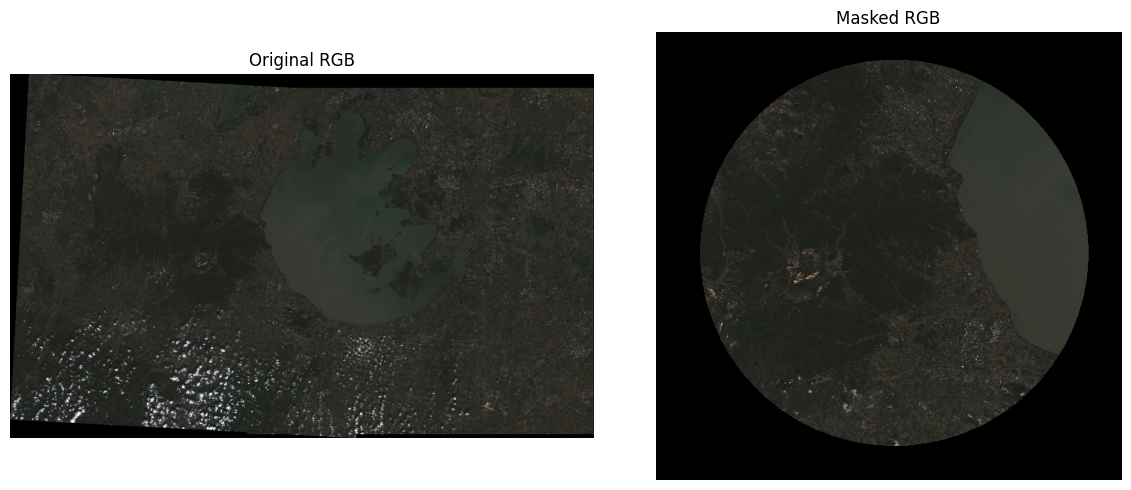

Original valid pixels: 600144336
Masked valid pixels: 58791912


In [14]:
# Step 1: Create AOI mask once
aoi_mask = create_aoi_mask(reference_profile, AOI_GDF)
mask_size = aoi_mask.shape
sub_dims = [(int(0.25*mask_size[0]), int(0.75*mask_size[0])), (int(0.225*mask_size[1]), int(0.55*mask_size[1]))]

if aoi_mask is not None:
    print(f"AOI mask created: {aoi_mask.shape}")
    print(f"AOI coverage: {aoi_mask.sum()} pixels ({aoi_mask.mean() * 100:.1f}%)")
    
    # Step 2: Apply to RGB (your rgb is likely height, width, bands)
    rgb_masked = apply_aoi_mask(rgb, aoi_mask)[sub_dims[0][0]:sub_dims[0][1], sub_dims[1][0]:sub_dims[1][1]]
    ns1s2_masked = apply_aoi_mask(ns1s2, aoi_mask)[sub_dims[0][0]:sub_dims[0][1], sub_dims[1][0]:sub_dims[1][1]]
    
    # Step 3: Apply to individual bands
    BAND_DATA_MASKED = {}
    for band_name, band_array in BAND_DATA.items():
        BAND_DATA_MASKED[band_name] = apply_aoi_mask(band_array, aoi_mask)[sub_dims[0][0]:sub_dims[0][1], sub_dims[1][0]:sub_dims[1][1]]
    
    # Step 4: Apply to masks
    cloud_probability_masked = apply_aoi_mask(cloud_probability, aoi_mask)[sub_dims[0][0]:sub_dims[0][1], sub_dims[1][0]:sub_dims[1][1]]
    SCL_masked = apply_aoi_mask(SCL, aoi_mask)[sub_dims[0][0]:sub_dims[0][1], sub_dims[1][0]:sub_dims[1][1]]
    
    # Display results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(rgb[::10, ::10])  # Downsampled original
    plt.title("Original RGB")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(rgb_masked[::10, ::10])  # Downsampled masked
    plt.title("Masked RGB")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Original valid pixels: {(rgb > 0).sum()}")
    print(f"Masked valid pixels: {(rgb_masked > 0).sum()}")
else:
    print("No AOI mask created - check AOI data")

## Phase 2: Vegetation Indices
- Implement NDVI, EVI, and optional SAVI with epsilon protection on denominators.
- Clip outputs to the [-1, 1] range and set invalid pixels to `NaN` using `MASKS`.
- Summarize each index with descriptive stats (min, max, mean, median, std, percentiles).
- Plot map panels and histograms to confirm distributions and detect anomalies.
- Flag out-of-range values before feeding indices into classification or biomass models.

### 2.1 Functions

In [17]:
# =============================================================================
# PHASE 2: Vegetation Index Calculation
# =============================================================================

def calculate_ndvi(red_band: np.ndarray, nir_band: np.ndarray, epsilon: float = 1e-8) -> np.ndarray:
    """
    Task 2.1: Calculate NDVI with division-by-zero protection.
    
    Formula: NDVI = (NIR - Red) / (NIR + Red + epsilon)
    Range: -1 to 1
    """
    numerator = nir_band - red_band
    denominator = nir_band + red_band + epsilon  # Add epsilon to avoid division by zero
    
    ndvi = numerator / denominator
    return np.clip(ndvi, -1.0, 1.0)  # Clip to valid range


def calculate_evi(red_band: np.ndarray, nir_band: np.ndarray, blue_band: np.ndarray, 
                  epsilon: float = 1e-8) -> np.ndarray:
    """
    Task 2.2: Calculate Enhanced Vegetation Index (EVI).
    
    Formula: EVI = 2.5 * (NIR - Red) / (NIR + 6*Red - 7.5*Blue + 1 + epsilon)
    Coefficients: Standard MODIS EVI coefficients (G=2.5, C1=6, C2=7.5, L=1)
    Range: -1 to 1
    """
    numerator = nir_band - red_band
    denominator = nir_band + 6.0 * red_band - 7.5 * blue_band + 1.0 + epsilon
    
    evi = 2.5 * (numerator / denominator)
    return np.clip(evi, -1.0, 1.0)  # Clip to valid range


def calculate_savi(red_band: np.ndarray, nir_band: np.ndarray, 
                   soil_adjustment: float = 0.5, epsilon: float = 1e-8) -> np.ndarray:
    """
    Task 2.3: Calculate Soil Adjusted Vegetation Index (SAVI).
    
    Formula: SAVI = (NIR - Red) / (NIR + Red + L) * (1 + L)
    L = soil adjustment factor (typically 0.5 for sparse vegetation)
    Range: -1 to 1
    """
    numerator = nir_band - red_band
    denominator = nir_band + red_band + soil_adjustment + epsilon
    
    savi = (numerator / denominator) * (1.0 + soil_adjustment)
    return np.clip(savi, -1.0, 1.0)  # Clip to valid range

Calculating vegetation indices...
✅ Vegetation indices calculated
Generating vegetation index maps...


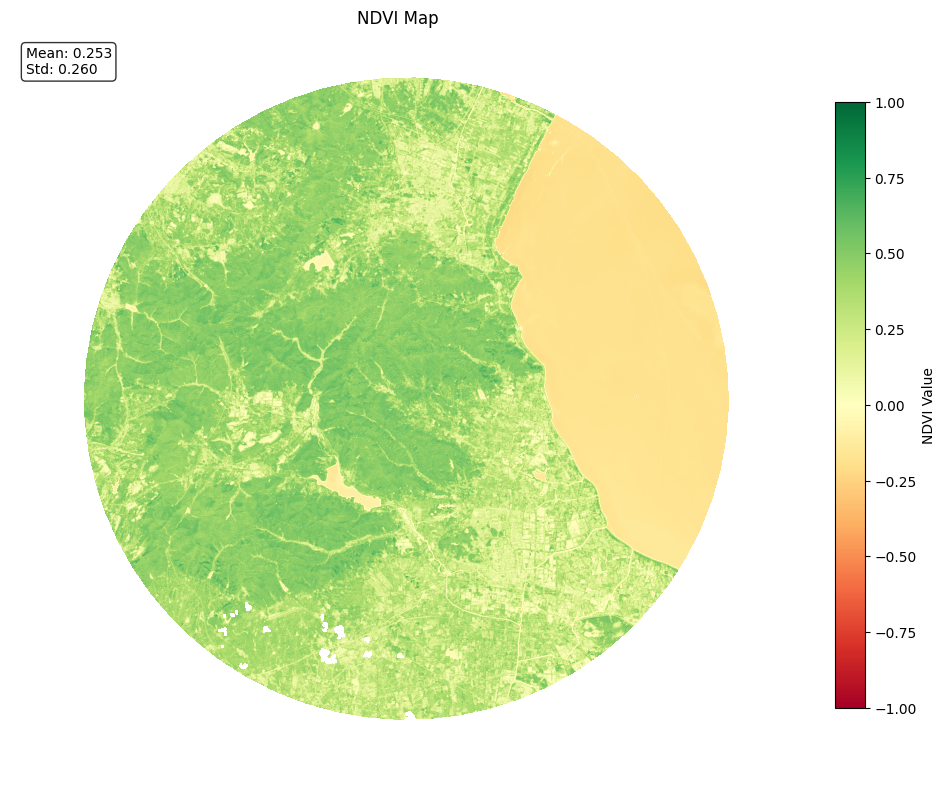

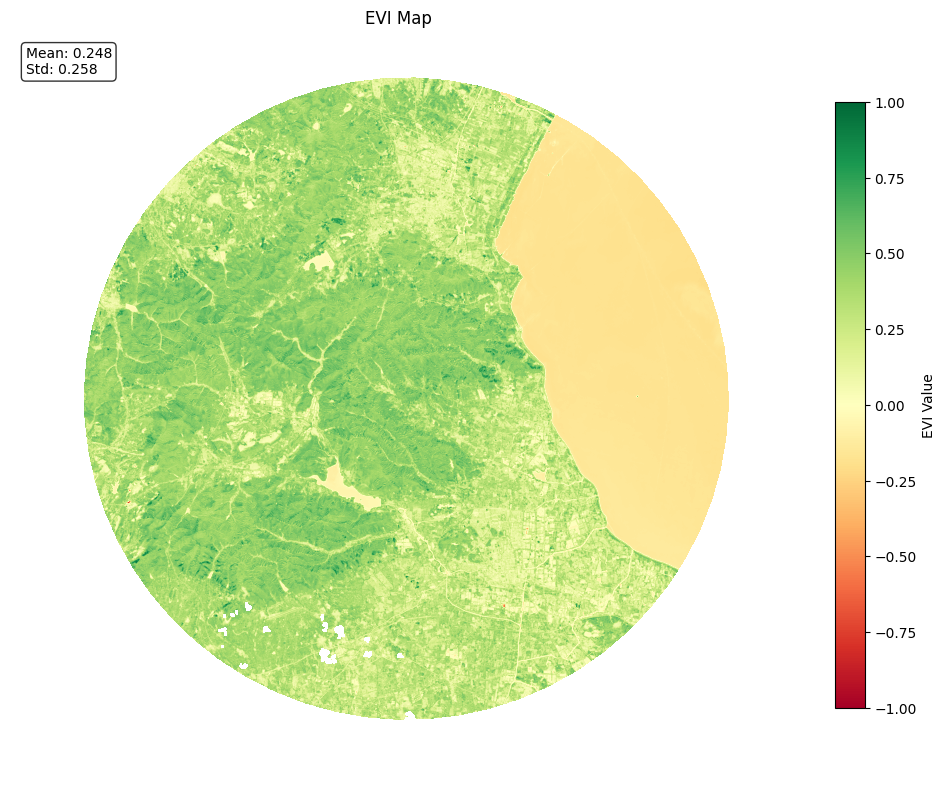

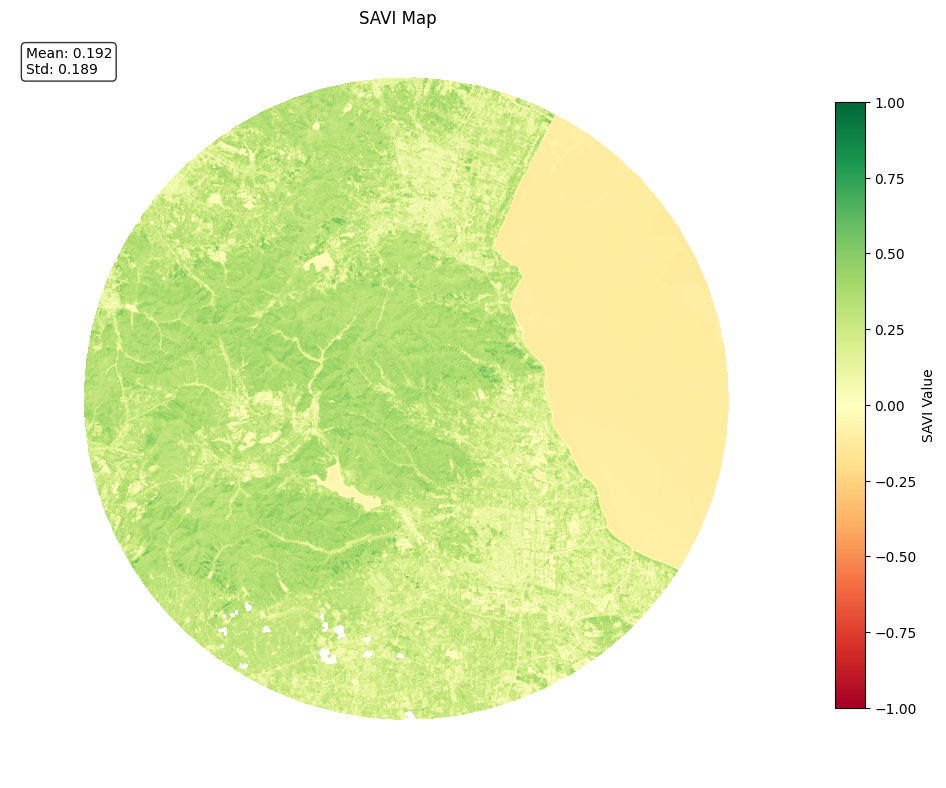

✅ Vegetation index maps generated
Validating vegetation index ranges...
NDVI Range Validation:
  Expected: [-1.0, 1.0]
  Actual:   [-0.9982, 0.8304]
  Status:   PASS
EVI Range Validation:
  Expected: [-1.0, 1.0]
  Actual:   [-1.0000, 1.0000]
  Status:   PASS
SAVI Range Validation:
  Expected: [-1.0, 1.0]
  Actual:   [-0.6787, 0.8141]
  Status:   PASS
✅ All vegetation indices passed range validation
Phase 2 completed successfully. Available indices: ['NDVI', 'EVI', 'SAVI']


In [ ]:
# =============================================================================
# Calculate Vegetation Indices
# =============================================================================

print("Calculating vegetation indices...")

# Extract required bands from masked data
red = BAND_DATA_MASKED["red"]
nir = BAND_DATA_MASKED["nir"]
blue = BAND_DATA_MASKED["blue"]

# Task 2.1-2.3: Calculate all vegetation indices
NDVI = calculate_ndvi(red, nir)
EVI = calculate_evi(red, nir, blue)
SAVI = calculate_savi(red, nir, soil_adjustment=0.5)  # L=0.5 for moderate soil adjustment

print("Vegetation indices calculated")

# =============================================================================
# Task 2.4: Create Visualization Maps
# =============================================================================
valid_mask_clipped = valid_mask[sub_dims[0][0]:sub_dims[0][1], sub_dims[1][0]:sub_dims[1][1]]
aoi_mask_clipped = aoi_mask[sub_dims[0][0]:sub_dims[0][1], sub_dims[1][0]:sub_dims[1][1]]

def plot_vegetation_index(index_array: np.ndarray, title: str, cmap: str = 'RdYlGn', 
                         vmin: float = -1, vmax: float = 1):
    """Helper function to create consistent vegetation index plots."""
    plt.figure(figsize=(10, 8))
    
    # Apply valid mask to clean up visualization
    masked_index = np.where(valid_mask_clipped & (aoi_mask_clipped if aoi_mask_clipped is not None else True), 
                           index_array, np.nan)
    
    plt.imshow(masked_index, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(label=f'{title} Value', shrink=0.8)
    plt.title(f'{title} Map')
    plt.axis('off')
    
    # Add basic statistics (only for valid pixels)
    valid_values = masked_index[~np.isnan(masked_index)]
    if len(valid_values) > 0:
        plt.text(0.02, 0.98, f'Mean: {valid_values.mean():.3f}\nStd: {valid_values.std():.3f}', 
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Create visualization maps for each index
print("Generating vegetation index maps...")

plot_vegetation_index(NDVI, 'NDVI')
plot_vegetation_index(EVI, 'EVI') 
plot_vegetation_index(SAVI, 'SAVI')

print("Vegetation index maps generated")

# =============================================================================
# Task 2.5: Validate Index Ranges
# =============================================================================

def validate_index_range(index_array: np.ndarray, index_name: str, expected_min: float = -1.0, expected_max: float = 1.0):
    """Validate that vegetation index values are within expected range."""
    actual_min = np.nanmin(index_array)
    actual_max = np.nanmax(index_array)
    
    print(f"{index_name} Range Validation:")
    print(f"  Expected: [{expected_min}, {expected_max}]")
    print(f"  Actual:   [{actual_min:.4f}, {actual_max:.4f}]")
    
    is_valid = (actual_min >= expected_min) and (actual_max <= expected_max)
    status = "PASS" if is_valid else "FAIL"
    print(f"  Status:   {status}")
    
    return is_valid

print("Validating vegetation index ranges...")

# Validate all indices
ndvi_valid = validate_index_range(NDVI, "NDVI")
evi_valid = validate_index_range(EVI, "EVI") 
savi_valid = validate_index_range(SAVI, "SAVI")

all_valid = ndvi_valid and evi_valid and savi_valid

if all_valid:
    print("All vegetation indices passed range validation")
else:
    print("Some vegetation indices failed range validation")

# =============================================================================
# Store Results for Later Use
# =============================================================================

VEGETATION_INDICES = {
    "NDVI": NDVI,
    "EVI": EVI, 
    "SAVI": SAVI
}

print(f"Phase 2 completed successfully. Available indices: {list(VEGETATION_INDICES.keys())}")

## Phase 3: Land Cover Classification
- Define NDVI-based thresholds for `non-forest`, `sparse`, `moderate`, and `dense` classes.
- Create a categorical raster using the thresholds and `MASKS["valid"]`.
- Calculate area (ha) per class using pixel area conversions.
- Plot a classification map with an intuitive color palette.
- Summarize counts/areas in a table for reporting.


## Phase 4: Biomass Estimation
- Select or cite an allometric equation suitable for the study region.
- Apply the equation pixel-wise to generate a biomass raster (tons/ha).
- Mask low-vegetation pixels (e.g., NDVI < 0.2) before aggregating.
- Enforce realistic min/max biomass bounds to avoid outliers.
- Compute total biomass (tons) using pixel area (0.01 ha at 10 m).
- Visualize biomass distribution with a legend and summary statistics.


## Phase 5: Analysis & Validation
- Derive descriptive stats (mean, median, std, min, max) for biomass and key indices.
- Build histograms/boxplots to inspect distributions and potential skew.
- Compare aggregated values to literature benchmarks for similar ecosystems.
- Conduct sensitivity checks on main parameters (e.g., NDVI thresholds, coefficients).
- Document assumptions, uncertainties, and data quality caveats.


## Phase 6: Water Detection
- Compute NDWI and MNDWI using the reflectance bands already loaded.
- Apply tuned thresholds to delineate water bodies.
- Separate water classes by permanence/intensity if possible.
- Calculate total water area and percentage of valid pixels.
- Map the water mask(s) with transparent overlays on RGB for QA.


## Phase 7: Water Quality
- Calculate a turbidity proxy such as the Normalized Difference Turbidity Index (NDTI).
- Restrict calculations to water pixels only.
- Create quality classes (e.g., healthy, moderate, degraded).
- Plot maps showing turbidity gradients.
- Note potential confounders (suspended sediment, sensor noise).


## Phase 8: Hydrological Analysis
- Build riparian buffer zones (30 m, 100 m, 300 m) using AOI geometry.
- Summarize NDVI or biomass statistics within each buffer to assess vegetation quality.
- Evaluate wetland connectivity metrics (distance to water, corridor quality, area).
- Flag priority conservation corridors based on connectivity + condition.
- Document formulas/assumptions for reproducibility.


## Phase 9: Ecosystem Service Quantification
- Translate biophysical metrics to per-pixel service scores for the five services.
- **Water Flow Regulation:** estimate water storage capacity using NDVI-based vegetation factors.
- **Water Purification:** compute pollutant removal capacity using NDVI and wetland area fractions.
- **Sediment Control:** approximate sediment retention via simplified USLE proxies (NDVI, buffers).
- **Aquifer Recharge:** estimate recharge potential with precipitation + NDVI-derived infiltration.
- **Flood Protection:** approximate flood storage using floodplain extent, storage depth, roughness.
- Produce maps and tables for each service, highlight hotspots.


## Phase 10: Dynamic Ecosystem Service Valuation
- Assign base value coefficients ($/ha/year) to each service (per README guidance).
- Derive Quality, Scarcity, and Benefit multipliers from indices and contextual data.
- Compute per-pixel dynamic value = base × quality × scarcity × benefit.
- Aggregate to total annual value and unit value (per ha) for the AOI.
- Generate valuation maps and concise summary tables.


## Phase 11: Documentation & Presentation
- Write a clear methodology narrative covering input data, preprocessing, models, and assumptions.
- Export publication-ready figures (maps, histograms, tables) with consistent styling.
- Compile a concise PDF report (3–5 pages) summarizing objectives, methods, results, discussion.
- Prepare a short slide deck (≈5 minutes) highlighting key insights and visuals.
- Ensure notebook cells are clean, commented, and reproducible for final submission.
